In [7]:
# import libraries:
#
import datetime
#
from sklearn.cluster import KMeans
#
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta
import yfinance as yf

In [8]:
# get asset of interest: SP500 ticker:
asset = '^GSPC'
end_time = datetime.date.today()
# start_time = end_time - datetime.timedelta(days = 11850)
start_time = end_time - datetime.timedelta(days = 1850)
df = yf.download(asset, start=start_time, end=end_time)
df_orig = yf.download(asset, start=start_time, end=end_time)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
# retrieve additional features:
# VIX at close prices
VIX = yf.download('^VIX', start=start_time, end=end_time)
df['VIX']=VIX['Close']
# compute ATR technical indicator
df.ta.atr(length=14, append=True)
# compute relative Volume on a rolling basis
df['relative_Vol'] = df['Volume']/df['Volume'].rolling(40).mean()
# get the daily returns of SPX500 to perform the regime detection:
df['return'] = df['Close'] - df['Close'].shift(1)

[*********************100%***********************]  1 of 1 completed


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\manuz\AppData\Local\Temp\ipykernel_16052\3576421940.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


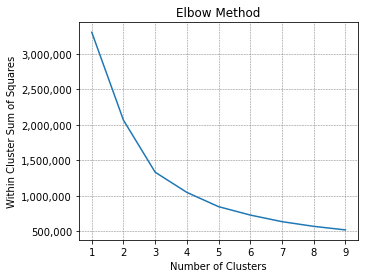

In [10]:
# Elbow method to find optimal number of regimes

df = df[['return', 'VIX', 'ATRr_14', 'relative_Vol']]

df = df[40:]
df_orig = df_orig[40:]

#within cluster sum of squares:
wcss = []

num_clusters = list(range(1,10))

for i in num_clusters:
    kmeans=KMeans(i)
    kmeans.fit(df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
fig = plt.figure(figsize =(5, 4))
plt.plot(num_clusters,wcss)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Elbow Method')
plt.ylabel('Within Cluster Sum of Squares')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(min(num_clusters), max(num_clusters)+1, 1.0))
plt.ticklabel_format(style='plain')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels([round(x) for x in current_values])
plt.show()

In [11]:
# It seems that it is optimal to choose 3 or 4 clusters/regimes so let’s go ahead with 3 clusters.
kmeans_num = 3
kmeans = KMeans(kmeans_num)
df['regime'] = kmeans.fit_predict(df)
df_orig['regime'] = df['regime']

In [12]:
print(df)


               return        VIX    ATRr_14  relative_Vol  regime
Date                                                             
2017-12-01  -5.360107  11.430000  17.251054      1.162443       0
2017-12-04  -2.780029  11.680000  17.919422      1.176403       0
2017-12-05  -9.869873  11.330000  18.148960      1.026925       0
2017-12-06  -0.300049  11.020000  17.516471      0.935139       0
2017-12-07   7.709961  10.160000  17.289440      0.951322       0
...               ...        ...        ...           ...     ...
2022-10-24  44.590088  29.850000  89.157424      1.076263       2
2022-10-25  61.770020  28.459999  87.468323      1.086267       2
2022-10-26 -28.510010  27.280001  85.654860      1.070712       1
2022-10-27 -23.300049  27.389999  83.548078      1.036696       1
2022-10-28  93.760010  25.750000  84.588920      0.982460       2

[1236 rows x 5 columns]


In [13]:
print(df_orig)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-12-01  2645.100098  2650.620117  2605.520020  2642.219971  2642.219971   
2017-12-04  2657.189941  2665.189941  2639.030029  2639.439941  2639.439941   
2017-12-05  2639.780029  2648.719971  2627.729980  2629.570068  2629.570068   
2017-12-06  2626.239990  2634.409912  2624.750000  2629.270020  2629.270020   
2017-12-07  2628.379883  2640.989990  2626.530029  2636.979980  2636.979980   
...                 ...          ...          ...          ...          ...   
2022-10-24  3762.010010  3810.739990  3741.649902  3797.340088  3797.340088   
2022-10-25  3799.439941  3862.850098  3799.439941  3859.110107  3859.110107   
2022-10-26  3825.969971  3886.149902  3824.070068  3830.600098  3830.600098   
2022-10-27  3834.689941  3859.949951  3803.790039  3807.300049  3807.300049   
2022-10-28  3808.260010  3905.419922  3808.260010  3

C:\Users\manuz\AppData\Local\Temp\ipykernel_16052\3629409398.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


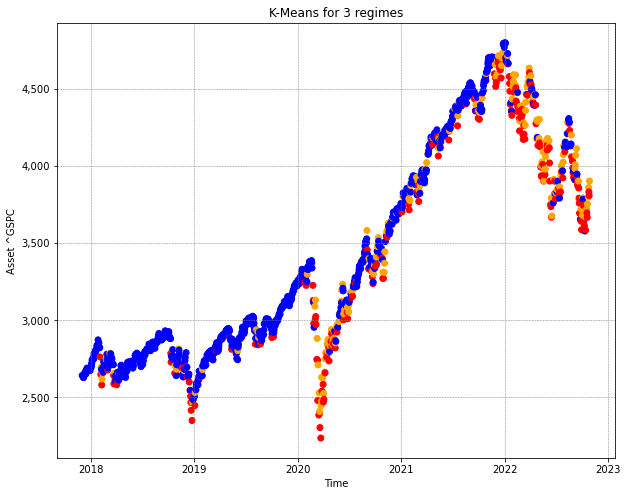

In [14]:
# Plot regimes

colours = []
vcs = {v: i for i, v in enumerate(df_orig.regime.value_counts().index)}
df_orig['freq_rank'] = df_orig.regime.apply(vcs.get)

for i in range(0,len(df_orig)):
    if df_orig['freq_rank'].iloc[i]==0:
        colours.append('blue')
    elif df_orig['freq_rank'].iloc[i]==1:
        colours.append('red')
    elif df_orig['freq_rank'].iloc[i]==2:
        colours.append('orange')
    else:
        colours.append('brown')
        
fig = plt.figure(figsize =(10, 8))
plt.scatter(df_orig.index, df_orig.Close, c=colours)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title(f'K-Means for {kmeans_num} regimes')
plt.ylabel(f'Asset {asset}')
plt.xlabel('Time')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()